# Transform 2021 NLP demo by Anne Estoppey

## Introduction
In this Jupyter Notebook, we will explore different aspects of NLP (Natural Language Processing). We will use well report summaries which are published by the NPD (Norwegian Petroleum Directorate), by requesting via an API. We will go through the different stages of text cleaning and formatting before moving on to NLP processing: tockenization, lemmatization and finally topic modeling.<br>

Level: intermediate. We expect participants to be familiar with mid level programming in python. Please see the requirements file and readme on the github repo.<br>

The well report summaries are available here: https://hotell.difi.no/?dataset=npd/wellbore/with-history (well report summaries).<br> 

The following link should go to all data available from Norwegian Oil Directorate, in public domain: https://data.norge.no/datasets/4304aea1-53b1-47ed-beae-52bf4d3642f3 (link might get broken over time).<br>

#### Requirements - specific libraries for NLP
This notebook was run with Python version 3.7.4, from Jupyter lab. <br>
<b>spaCy: </b>free, open-source library for advanced Natural Language Processing (NLP) in Python.<br>
More about spaCy <a href="https://spacy.io/usage/spacy-101"> here.</a><br>
<b>gensim: </b> Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora (where 'corpus' or 'corpora' is collection of texts).<br>
More about gensim <a href="https://pypi.org/project/gensim/"> here.</a><br>
<b>pyLDAvis: </b>is designed to help users interpret the topics in a topic model that has been fit to a collection of text data.<br>
<b>Important: </b>You will need the following version of pyLDAvis for the topics visualisation: pyLDAvis 2.1.2
<br>You'll need to install pyLDAvis 2.1.2 from PIP!<br>
More about pyLDAvis and topic modelling <a href="https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know"> here.</a><br>
#### How to fix blank maps and graph in jupyter lab!!
Check out link <a href="https://stackoverflow.com/questions/54936125/plotly-gives-an-empty-field-as-output-in-jupyter-lab"> here.</a><br>
To check if your jupyter lab plotly extension is up and running: > jupyter labextension list

---

In [304]:
import pandas as pd
import numpy as np
from pprint import pprint
import re, os, operator
import collections 
import matplotlib.pyplot as plt
import requests
import json
import warnings

import geopandas as gpd

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import spacy # spacy - text comprehension package

# gensim - topic modeling package
import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from wordcloud import WordCloud

In [305]:
warnings.filterwarnings('ignore')

In [306]:
#### REMOVE THIS BEFORE DEMO, THIS IS FOR TESTING! ####

# set max number of rows for pandas
pd.set_option('display.max_rows', 2000)

#### API connection - check for status
Make a general get request, print out status code. 
Status code = 200 means API connection is up and running.

In [307]:
requests.get('https://data.norge.no/api/dcat/870917732/data.json')

<Response [200]>

#### Get request - Well summaries
The datasets are paginated. The first page will tell us how many pages there are in total, and how many rows for the whole dataset.

In [308]:
wells_summary = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-history?page=1')
json_wells_summary = wells_summary.json()
print(f'number of pages: {json_wells_summary["pages"]}')
print(f'number of rows:  {json_wells_summary["posts"]}')

number of pages: 19
number of rows:  1825


#### Let's go through all the pages and append all the rows in JSON dictionary
Create a pandas dataframe from the json file

In [309]:
def get_all_data(url_dataset, df_out_name):
    '''getting number of pages,
    looping through all pages,
    append in JSON dictionary,
    create dataframe
    '''
    wells_summary = requests.get(url_dataset)
    json_count_page = wells_summary.json()
    
    page = json_count_page['pages']
    all_data_list = []
    for i in range(0, page):
        url = url_dataset + f'?page={i+1}'
        dataset_all = requests.get(url)
        dataset_all_json = dataset_all.json()
        number_of_entries = len(dataset_all_json['entries'])

        for entry in range(0, number_of_entries):
            all_data_list.append(dataset_all_json['entries'][entry])

    df_out_name = pd.DataFrame(all_data_list)
    return df_out_name

#### Getting all our well summaries into a dataframe

In [310]:
url_dataset ='https://hotell.difi.no/api/json/npd/wellbore/with-history'
df_out_name = 'df_all_summaries'
# json_count_page = json_wells_summary  # total number of pages (pagination)
df_all_summaries = get_all_data(url_dataset, df_out_name)

In [311]:
df_all_summaries.shape

(1825, 5)

In [312]:
df_all_summaries.head()

,wlbHistoryDateUpdated,wlbName,wlbNPDID_wellbore,wlbHistory,datesyncNPD
0,7/6/2016 12:00:00 AM,1/2-1,1382,<p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...,01.04.2021
1,4/11/2017 12:00:00 AM,1/2-2,5192,<p>The 1/2-2 well was drilled to evaluate the ...,01.04.2021
2,5/19/2016 12:00:00 AM,1/3-1,154,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,01.04.2021
3,4/11/2017 12:00:00 AM,1/3-10,5614,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,01.04.2021
4,4/11/2017 12:00:00 AM,1/3-10 A,5779,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,01.04.2021


In [313]:
# check for duplicate wells!
def check_for_duplicates(df, column_name):
    boolean = df[column_name].duplicated().any()
    if boolean == True:
        pd.concat(g for _, g in df.groupby(column_name) if len(g) > 1)
    else:
        print("No duplicates!")
    return

In [314]:
check_for_duplicates(df_all_summaries, 'wlbName')

No duplicates!


#### Display a complete summary - we will need to clean all this html code!

In [315]:
# Display well summary (wlbHistory) 
df_all_summaries.iloc[1500]['wlbHistory']

'<b>\nGeneral\n</b>\n<p>\nWell 6508/1-1 S was drilled in between the Norne Field and the Nordland Ridge. Well 6508/1- 1 A was sidetracked from below the 13 3/8" casing shoe in 6508/1-1 S. Water based mud was used in both well tracks.\nThe main purpose of 6508/1-1 S was to test for the presence of hydrocarbons in the Middle Jurassic, Fangst Group. The secondary purposes were to test for the presence of hydrocarbons in the sandstone immediately above the Tertiary-Cretaceous boundary (Paleocene-Campanian) as well as for possible sandstones in the Cretaceous succession, in the Upper Jurassic Melke Formation, and in lower Jurassic Båt Group.\nThe main purpose of 6508/1-1 A was to test for the presence of hydrocarbons in the Upper Jurassic Rogn Formation. The secondary objective was to test for the presence of sandstone and hydrocarbons both above and below the Tertiary-Cretaceous boundary (Paleocene-Campanian), possible sandstones in the Cretaceous succession, in the Upper Jurassic Melke Fo

#### Getting geolocation information for all wells - we will append this information to our well summary dataframe

In [316]:
wells_with_coordinates = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-coordinates?page=1')
json_wells_with_coordinates = wells_with_coordinates.json()
print(f'number of pages: {json_wells_with_coordinates["pages"]}')
print(f'number of rows:  {json_wells_with_coordinates["posts"]}')

number of pages: 85
number of rows:  8485


In [317]:
url_dataset = 'https://hotell.difi.no/api/json/npd/wellbore/with-coordinates'
df_out_name = 'df_all_with_coord'
# json_count_page = json_wells_with_coordinates  # total pagination number
df_all_with_coord = get_all_data(url_dataset, df_out_name)

In [318]:
df_all_with_coord.shape

(8485, 26)

In [319]:
df_all_with_coord.head()

,wlbUtmZone,wlbWellType,wlbEwDeg,wlbEwCode,wlbEntryDate,wlbNsSec,wlbEwMin,wlbEwSec,wlbNsDecDeg,wlbProductionLicence,...,wlbEwUtm,wlbNsMin,wlbWellboreName,wlbContent,wlbDrillingOperator,wlbEwDesDeg,wlbNsUtm,wlbGeodeticDatum,datesyncNPD,wlbMainArea
0,31,EXPLORATION,2,E,20.03.1989,15.07,28,35.7,56.887519,143,...,468106.29,53,1/2-1,OIL,Phillips Petroleum Norsk AS,2.476583,6305128.26,ED50,01.04.2021,NORTH SEA
1,31,EXPLORATION,2,E,14.12.2005,32,29,47.66,56.992222,143 CS,...,469410.10,59,1/2-2,OIL SHOWS,Paladin Resources Norge AS,2.496572,6316774.33,ED50,01.04.2021,NORTH SEA
2,31,OTHER,2,E,09.05.2009,55.58,27,5.01,56.948772,143,...,466625.99,56,1/2-U-1,,ConocoPhillips Skandinavia AS,2.451392,6311958.73,ED50,01.04.2021,NORTH SEA
3,31,OTHER,2,E,12.05.2009,56.95,27,7.69,56.949153,143,...,466671.62,56,1/2-U-2,,ConocoPhillips Skandinavia AS,2.452136,6312000.73,ED50,01.04.2021,NORTH SEA
4,31,OTHER,2,E,12.05.2009,54.99,27,8.52,56.948608,143,...,466685.16,56,1/2-U-3,,ConocoPhillips Skandinavia AS,2.452367,6311940.01,ED50,01.04.2021,NORTH SEA


In [320]:
# check for duplicate wells!
check_for_duplicates(df_all_with_coord, 'wlbWellboreName')

No duplicates!


#### Having a quick check on a map with our dataframe with coordinates

In [321]:
df_all_with_coord['wlbNsDecDeg'] = df_all_with_coord['wlbNsDecDeg'].astype(float).round(3)
df_all_with_coord['wlbEwDesDeg'] = df_all_with_coord['wlbEwDesDeg'].astype(float).round(3)

In [322]:
df_all_with_coord.dtypes

wlbUtmZone               object
wlbWellType              object
wlbEwDeg                 object
wlbEwCode                object
wlbEntryDate             object
wlbNsSec                 object
wlbEwMin                 object
wlbEwSec                 object
wlbNsDecDeg             float64
wlbProductionLicence     object
wlbNsDeg                 object
wlbNpdidWellbore         object
wlbPurposePlanned        object
wlbField                 object
wlbNsCode                object
wlbCompletionDate        object
wlbEwUtm                 object
wlbNsMin                 object
wlbWellboreName          object
wlbContent               object
wlbDrillingOperator      object
wlbEwDesDeg             float64
wlbNsUtm                 object
wlbGeodeticDatum         object
datesyncNPD              object
wlbMainArea              object
dtype: object

#### Drawing scatter map function

In [323]:
def drawScatterMap(dataframe, colorColumn, title):
    fig = px.scatter_mapbox(dataframe, 
                            lat="wlbNsDecDeg", lon="wlbEwDesDeg", 
                            color=colorColumn, 
                            width=1000, height=1000, 
                            # color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
                            color_discrete_sequence=px.colors.qualitative.D3,
                            center={'lat':71, 'lon':20},
                            zoom=3, 
                            # mapbox_style="stamen-watercolor",
                            mapbox_style="carto-positron",
                            title=title
                            )


    return fig.show()

In [324]:
#### A few words about plotly express here! ####

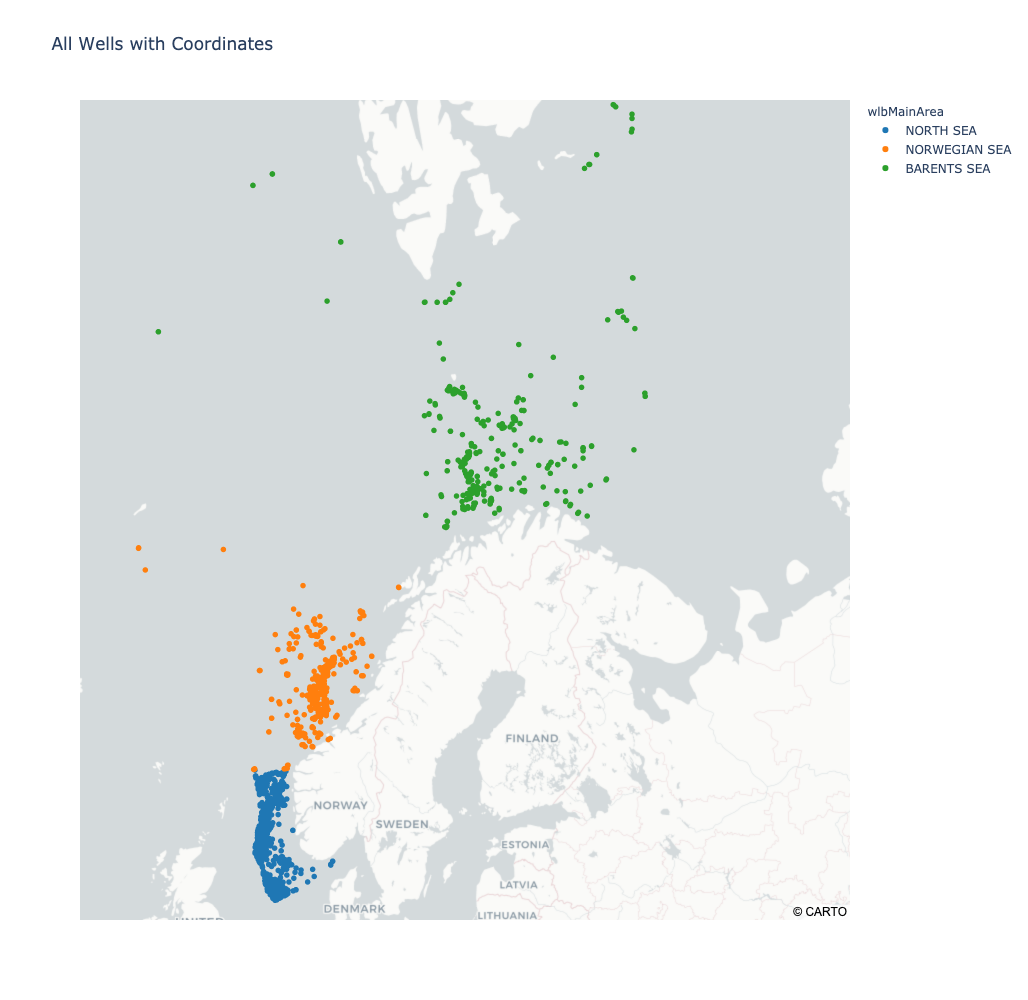

In [325]:
drawScatterMap(df_all_with_coord, 'wlbMainArea', 'All Wells with Coordinates')

In [326]:
df_all_with_coord.wlbMainArea.unique()

array(['NORTH SEA', 'NORWEGIAN SEA', 'BARENTS SEA'], dtype=object)

#### Merging df_all_with_coord together with df_all_summaries to get coordinates in the summary df

In [327]:
df_summaries_coord = pd.merge(df_all_summaries, 
                              df_all_with_coord[['wlbEwDesDeg', 'wlbNsDecDeg', 'wlbEwUtm', 'wlbNsUtm',
                                                 'wlbWellboreName', 'wlbContent', 'wlbMainArea', 'wlbDrillingOperator', 'wlbWellType']], how='left',
                              left_on='wlbName', right_on='wlbWellboreName')

In [328]:
df_summaries_coord.shape

(1825, 14)

In [329]:
df_summaries_coord.head()

,wlbHistoryDateUpdated,wlbName,wlbNPDID_wellbore,wlbHistory,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbContent,wlbMainArea,wlbDrillingOperator,wlbWellType
0,7/6/2016 12:00:00 AM,1/2-1,1382,<p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...,01.04.2021,2.477,56.888,468106.29,6305128.26,1/2-1,OIL,NORTH SEA,Phillips Petroleum Norsk AS,EXPLORATION
1,4/11/2017 12:00:00 AM,1/2-2,5192,<p>The 1/2-2 well was drilled to evaluate the ...,01.04.2021,2.497,56.992,469410.10,6316774.33,1/2-2,OIL SHOWS,NORTH SEA,Paladin Resources Norge AS,EXPLORATION
2,5/19/2016 12:00:00 AM,1/3-1,154,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,01.04.2021,2.851,56.856,490936.87,6301488.86,1/3-1,GAS,NORTH SEA,A/S Norske Shell,EXPLORATION
3,4/11/2017 12:00:00 AM,1/3-10,5614,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,01.04.2021,2.706,56.928,482089.29,6309521.94,1/3-10,OIL/GAS,NORTH SEA,DONG E&P Norge AS,EXPLORATION
4,4/11/2017 12:00:00 AM,1/3-10 A,5779,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,01.04.2021,2.706,56.928,482089.29,6309521.94,1/3-10 A,OIL/GAS,NORTH SEA,DONG E&P Norge AS,EXPLORATION


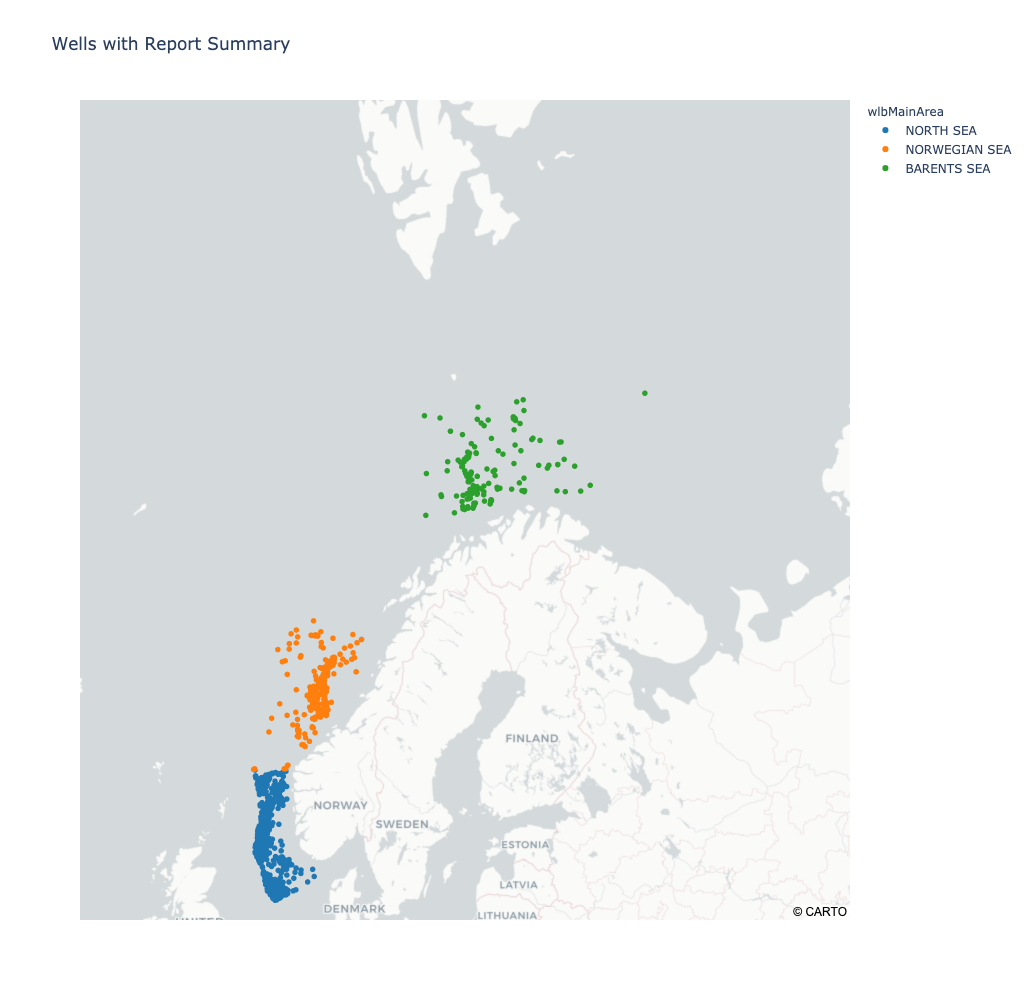

In [330]:
drawScatterMap(df_summaries_coord, 'wlbMainArea', 'Wells with Report Summary')

---

#### Starting cleaning of well summaries in the dataframe

In [331]:
# creating a copy of dataframe
df_summaries_coord_clean = df_summaries_coord.copy()
df_summaries_coord_clean.shape

(1825, 14)

#### We start with some basic text cleaning (removing html and new line tags, and replacing bad quotation tags).
We create a new attribute 'wlbHistory_clean' with the resulting clean texts.

In [332]:
def cleanhtml():
    # remove html tags
    cleanr = re.compile('<.*?>')
    
    rows = df_summaries_coord_clean['wlbHistory']
    listcleantext = []
    for r in rows:
        cleantext = re.sub(cleanr, '', r)
        
        # replace new line \n with empty space
        cleantext = cleantext.replace('\n', ' ')
        
        # replace &quot; with single quote (inch)
        cleantext = cleantext.replace('&quot;', "''")
        
        listcleantext.append(cleantext)
    df_summaries_coord_clean['wlbHistory_clean'] = listcleantext
    return

In [333]:
cleanhtml()

In [334]:
df_summaries_coord_clean.shape

(1825, 15)

In [363]:
df_summaries_coord_clean.head()

,wlbHistoryDateUpdated,wlbName,wlbNPDID_wellbore,wlbHistory,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbContent,wlbMainArea,wlbDrillingOperator,wlbWellType,wlbHistory_clean
0,7/6/2016 12:00:00 AM,1/2-1,1382,<p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...,01.04.2021,2.477,56.888,468106.29,6305128.26,1/2-1,OIL,NORTH SEA,Phillips Petroleum Norsk AS,EXPLORATION,General Well 1/2-1 is located in the Central ...
1,4/11/2017 12:00:00 AM,1/2-2,5192,<p>The 1/2-2 well was drilled to evaluate the ...,01.04.2021,2.497,56.992,469410.10,6316774.33,1/2-2,OIL SHOWS,NORTH SEA,Paladin Resources Norge AS,EXPLORATION,The 1/2-2 well was drilled to evaluate the pro...
2,5/19/2016 12:00:00 AM,1/3-1,154,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,01.04.2021,2.851,56.856,490936.87,6301488.86,1/3-1,GAS,NORTH SEA,A/S Norske Shell,EXPLORATION,General Well 1/3-1 was drilled on the crest o...
3,4/11/2017 12:00:00 AM,1/3-10,5614,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,01.04.2021,2.706,56.928,482089.29,6309521.94,1/3-10,OIL/GAS,NORTH SEA,DONG E&P Norge AS,EXPLORATION,General Well 1/3-10 is located on the Hidra H...
4,4/11/2017 12:00:00 AM,1/3-10 A,5779,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,01.04.2021,2.706,56.928,482089.29,6309521.94,1/3-10 A,OIL/GAS,NORTH SEA,DONG E&P Norge AS,EXPLORATION,General Well 1/3-10 A is located on the Hidra...


In [336]:
rawtext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory']
# rawtext_sample

In [337]:
cleantext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory_clean']
# cleantext_sample

In [338]:
# counting words in string (simple count based on white space between words)
len(cleantext_sample.split())

689

---

### Pre-processing for NLP

We continue with our dataframe 'df_summaries_coord_clean'

#### We calculate the average length (number of words) for all summaries in dataframe wlbHistory_clean:

In [339]:
print('Average wlbHistory length: ' + str(df_summaries_coord_clean["wlbHistory_clean"].str.split().str.len().mean()))

Average wlbHistory length: 408.0213698630137


#### We can enter a well name, and its summary will be grabbed for cleaning and then displaying in a wordcloud.

In [364]:
wellname = input('Please enter well name: ')

Please enter well name:  6406/2-1


In [365]:
try:
    wi1 = next(iter(df_summaries_coord_clean[df_summaries_coord_clean['wlbName']== wellname].index), 'no match')
    wi2 = wi1 + 1
    # print(wi1)
    # print(wi2)
except:
    print('Please enter well name in proper format. Examples: 1/3-5, 1/3-9 S, 6406/2-1')

#### We create a list of strings, where each well summary is a separate string.

In [366]:
wlbHistory_clean_to_list = df_summaries_coord_clean["wlbHistory_clean"].values.tolist()

#### Let's have a look at one sample (wi1 and wi2 are in fact index values for a given well in dataframe)

In [367]:
pprint(wlbHistory_clean_to_list[wi1:wi2])

[' General   Exploration well 6406/2-1 was drilled on the B-prospect east in '
 'the block 6406/2, south of the Smørbukk Field and west of the Trestakk Field '
 'on Haltenbanken. The main purpose was to test the B-prospect sandstones of '
 'Middle to Early Jurassic age and the presence of hydrocarbons. Further, the '
 'reservoir quality at great depth (prognosed TD 5200 m) was to be tested. The '
 'main reservoir zones were prognosed to be the Ile and Tilje Formations, both '
 'prognosed to consist of mica-bearing sandstones with thin shale layers. The '
 'Garn and Tofte Formations, expected to be purer quartz-sandstones and more '
 'susceptible to diagenetic quartz cementation, were considered as additional '
 'potential.  Possible sandstones were also prognosed at three different '
 'levels within the Cromer Knoll Group (in the Lysing and Lange Formations, of '
 'Turonian and Cenomanian age), and the well 6406/2-1 was aimed to test these '
 'levels within structural closure.   Operat

#### We use regex (re) to do some more cleaning

In [368]:
wlbHistory_clean_to_list2 = []

for sentence in range(0, len(wlbHistory_clean_to_list)):
    
    # Add spaces if two words appear to be concatenated by mistake
    # wlbHistory_ = re.sub(r'(\w)([A-Z])', r'\1 \2', str(wlbHistory_clean_to_list[sentence]))
    
    # Remove prefixed 'b', if present
    # wlbHistory_ = re.sub(r'^b\s+', '', wlbHistory_)
    
    # remove all numbers ### this seems to be done by default anyway!
    # wlbHistory_ = re.sub(r'\d+','', wlbHistory_)
    
    # Remove single characters from the start
    # wlbHistory_ = re.sub(r'\^[a-zA-Z]\s+', ' ', wlbHistory_)
    wlbHistory_ = re.sub(r'\^[a-zA-Z]\s+', ' ', str(wlbHistory_clean_to_list[sentence]))
    
    # Remove all the special characters
    wlbHistory_ = re.sub(r'\W', ' ', wlbHistory_)

    # Substituting multiple spaces with single space
    wlbHistory_ = re.sub(r'\s+', ' ', wlbHistory_, flags=re.I)

    wlbHistory_clean_to_list2.append(wlbHistory_)

In [369]:
pprint(wlbHistory_clean_to_list2[wi1:wi2])

[' General Exploration well 6406 2 1 was drilled on the B prospect east in the '
 'block 6406 2 south of the Smørbukk Field and west of the Trestakk Field on '
 'Haltenbanken The main purpose was to test the B prospect sandstones of '
 'Middle to Early Jurassic age and the presence of hydrocarbons Further the '
 'reservoir quality at great depth prognosed TD 5200 m was to be tested The '
 'main reservoir zones were prognosed to be the Ile and Tilje Formations both '
 'prognosed to consist of mica bearing sandstones with thin shale layers The '
 'Garn and Tofte Formations expected to be purer quartz sandstones and more '
 'susceptible to diagenetic quartz cementation were considered as additional '
 'potential Possible sandstones were also prognosed at three different levels '
 'within the Cromer Knoll Group in the Lysing and Lange Formations of Turonian '
 'and Cenomanian age and the well 6406 2 1 was aimed to test these levels '
 'within structural closure Operations and results Well 

#### We change (transform) strings to bag-of-words. 

In [370]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

bag_of_words = list(sent_to_words(wlbHistory_clean_to_list2))

print(bag_of_words[wi1:wi2])

[['general', 'exploration', 'well', 'was', 'drilled', 'on', 'the', 'prospect', 'east', 'in', 'the', 'block', 'south', 'of', 'the', 'smørbukk', 'field', 'and', 'west', 'of', 'the', 'trestakk', 'field', 'on', 'haltenbanken', 'the', 'main', 'purpose', 'was', 'to', 'test', 'the', 'prospect', 'sandstones', 'of', 'middle', 'to', 'early', 'jurassic', 'age', 'and', 'the', 'presence', 'of', 'hydrocarbons', 'further', 'the', 'reservoir', 'quality', 'at', 'great', 'depth', 'prognosed', 'td', 'was', 'to', 'be', 'tested', 'the', 'main', 'reservoir', 'zones', 'were', 'prognosed', 'to', 'be', 'the', 'ile', 'and', 'tilje', 'formations', 'both', 'prognosed', 'to', 'consist', 'of', 'mica', 'bearing', 'sandstones', 'with', 'thin', 'shale', 'layers', 'the', 'garn', 'and', 'tofte', 'formations', 'expected', 'to', 'be', 'purer', 'quartz', 'sandstones', 'and', 'more', 'susceptible', 'to', 'diagenetic', 'quartz', 'cementation', 'were', 'considered', 'as', 'additional', 'potential', 'possible', 'sandstones', '

#### Removing stop words from bag-of-words

In [382]:
stop_words = stopwords.words('english')
stop_words.extend(['formation', 'formations', 'group', 'core', 'sm', 'well', 'zone', 'drilled', 'target', 
                   'reservoir', 'primary', 'hole', 'mud', 'cut'])
# --> we can add extra words here that we want to remove from the bag of words

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

bag_of_words_no_stop = remove_stopwords(bag_of_words)

In [383]:
print(bag_of_words_no_stop[wi1:wi2])

[['general', 'exploration', 'prospect', 'east', 'block', 'south', 'smørbukk', 'field', 'west', 'trestakk', 'field', 'haltenbanken', 'main', 'purpose', 'test', 'prospect', 'sandstones', 'middle', 'early', 'jurassic', 'age', 'presence', 'hydrocarbons', 'quality', 'great', 'depth', 'prognosed', 'td', 'tested', 'main', 'zones', 'prognosed', 'ile', 'tilje', 'prognosed', 'consist', 'mica', 'bearing', 'sandstones', 'thin', 'shale', 'layers', 'garn', 'tofte', 'expected', 'purer', 'quartz', 'sandstones', 'susceptible', 'diagenetic', 'quartz', 'cementation', 'considered', 'additional', 'potential', 'possible', 'sandstones', 'also', 'prognosed', 'three', 'different', 'levels', 'within', 'cromer', 'knoll', 'lysing', 'lange', 'turonian', 'cenomanian', 'age', 'aimed', 'test', 'levels', 'within', 'structural', 'closure', 'operations', 'results', 'spudded', 'october', 'semi', 'submersible', 'ross', 'rig', 'due', 'environmental', 'restrictions', 'area', 'drilling', 'operations', 'stopped', 'april', 'te

In [384]:
len(bag_of_words_no_stop) # --> this should still return the same length of our original 'df_all_summaries' dataframe :)

1825

---

### Creating WordCloud

#### We first flatten 'bag_of_words_no_stop[wi1:wi2]' into a non nested list

In [385]:
t = bag_of_words_no_stop[wi1:wi2]
flat_list = []
for sublist in t:
    for item in sublist:
        flat_list.append(item)

In [386]:
print(flat_list)

['general', 'exploration', 'prospect', 'east', 'block', 'south', 'smørbukk', 'field', 'west', 'trestakk', 'field', 'haltenbanken', 'main', 'purpose', 'test', 'prospect', 'sandstones', 'middle', 'early', 'jurassic', 'age', 'presence', 'hydrocarbons', 'quality', 'great', 'depth', 'prognosed', 'td', 'tested', 'main', 'zones', 'prognosed', 'ile', 'tilje', 'prognosed', 'consist', 'mica', 'bearing', 'sandstones', 'thin', 'shale', 'layers', 'garn', 'tofte', 'expected', 'purer', 'quartz', 'sandstones', 'susceptible', 'diagenetic', 'quartz', 'cementation', 'considered', 'additional', 'potential', 'possible', 'sandstones', 'also', 'prognosed', 'three', 'different', 'levels', 'within', 'cromer', 'knoll', 'lysing', 'lange', 'turonian', 'cenomanian', 'age', 'aimed', 'test', 'levels', 'within', 'structural', 'closure', 'operations', 'results', 'spudded', 'october', 'semi', 'submersible', 'ross', 'rig', 'due', 'environmental', 'restrictions', 'area', 'drilling', 'operations', 'stopped', 'april', 'tem

In [387]:
len(flat_list)

416

#### Converting our list to a long string of words separated by space, in order to create the WordCloud

In [388]:
flat_list_to_string = ''
flat_list_to_string += " ".join(flat_list)+" "

In [389]:
print(flat_list_to_string)

general exploration prospect east block south smørbukk field west trestakk field haltenbanken main purpose test prospect sandstones middle early jurassic age presence hydrocarbons quality great depth prognosed td tested main zones prognosed ile tilje prognosed consist mica bearing sandstones thin shale layers garn tofte expected purer quartz sandstones susceptible diagenetic quartz cementation considered additional potential possible sandstones also prognosed three different levels within cromer knoll lysing lange turonian cenomanian age aimed test levels within structural closure operations results spudded october semi submersible ross rig due environmental restrictions area drilling operations stopped april temporarily plugged abandoned april preliminary td total non productive time npt days reasons lost time mainly barrel stuck attempting pull leakages hose yellow pod shuttle valve mpr stuck radioactive logging tools unsuccessful attempts log rci fmt tools reentered august reached t

In [390]:
# define the WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stop_words, 
            min_font_size = 10).generate(flat_list_to_string)

In [391]:
def WordCloud_plot(wordcloud, wellname):
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(label="WordCloud for Well " + wellname + "\n\n",
             fontsize = 20,
             color = "black")

    plt.show()
    return

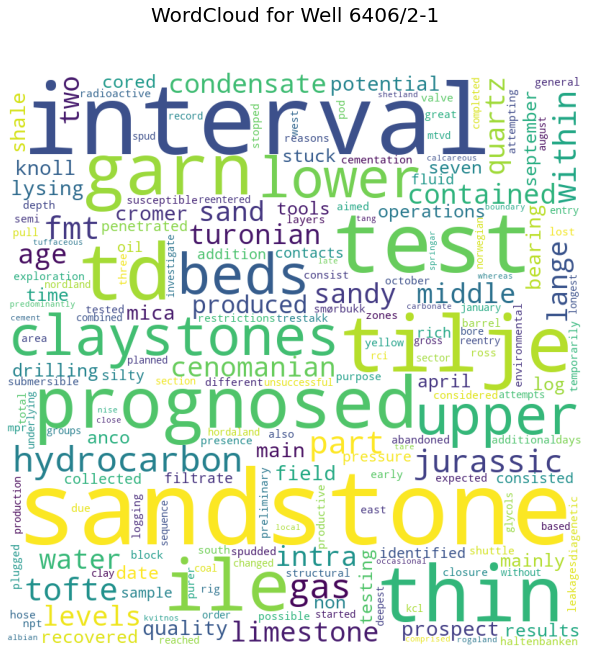

In [392]:
WordCloud_plot(wordcloud, wellname)

In [358]:
# %reset

---

## Processing all summaries
We are going to use 'bag_of_words_no_stop' which we created above. It's a list of list, where every element is a bag of word for each summary.

In [49]:
type(bag_of_words_no_stop)

list

In [50]:
len(bag_of_words_no_stop)

1824

In [51]:
path_spacey_model = '/anaconda3/envs/python37/lib/python3.7/site-packages/en_core_web_sm/en_core_web_sm-2.1.0' # path to our Spacey language model

In [52]:
# spaCy NLP library:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.1.0/en_core_web_sm-2.1.0.tar.gz
# github repo here: https://github.com/explosion/spacy-models

nlp = spacy.load(path_spacey_model, disable=['parser', 'ner']) # --> after running pip install in your github repo home directory, load the model

In [53]:
# Reducing the term count - FIRST STEP

# We have already removed our stop words (see above)

# The lemmatization will allow us to select a specific type of word, for instance 'NOUN'

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [54]:
bag_of_words_no_stop_lemma = lemmatization(bag_of_words_no_stop, allowed_postags=['NOUN'])

In [55]:
print(bag_of_words_no_stop_lemma[:1]) # --> I think it would be better to process WORDCLOUD on the lemmatization texts!

[['graben', 'border', 'north', 'sea', 'paleocene', 'rogaland', 'group', 'chalk', 'formation', 'operation', 'result', 'wildcat', 'installation', 'isle', 'march', 'tor', 'elevator', 'attempt', 'recover', 'string', 'success', 'cut', 'seawater', 'water', 'clay', 'borehole', 'seawater', 'gas', 'forty', 'hydrocarbon', 'bearing', 'log', 'rft', 'pressure', 'gradient', 'forty', 'property', 'porosity', 'test', 'permeability', 'md', 'core', 'rft', 'datum', 'water', 'gradient', 'oil', 'shift', 'psi', 'existence', 'barrier', 'saturation', 'fluorescence', 'existence', 'oil', 'barrier', 'log', 'test', 'lack', 'datum', 'point', 'ekofisk', 'tor', 'formation', 'water', 'bearing', 'core', 'forty', 'wire', 'line', 'fluid', 'sample', 'oil', 'gas', 'discovery', 'interval', 'intention', 'test', 'oil', 'produce', 'sample', 'water', 'interval', 'oil', 'water', 'oil', 'test', 'oil', 'gas', 'day', 'choke', 'oil', 'gravity', 'deg', 'api', 'temperature', 'test', 'deg', 'analysis', 'oil', 'water', 'test', 'perforat

In [56]:
mylist = bag_of_words_no_stop_lemma[:1]
myflatlist = []
for sublist in mylist:
    for item in sublist:
        myflatlist.append(item)

In [57]:
len(myflatlist)

107

In [58]:
print(bag_of_words_no_stop[:1]) # let's have a look at the same example BEFORE lemmatization

[['general', 'located', 'central', 'graben', 'uk', 'border', 'north', 'sea', 'main', 'objective', 'paleocene', 'sands', 'rogaland', 'group', 'secondary', 'chalk', 'formations', 'although', 'possibly', 'enough', 'fractured', 'represent', 'operations', 'results', 'wildcat', 'spudded', 'semi', 'submersible', 'installation', 'ross', 'isle', 'march', 'td', 'late', 'cretaceous', 'tor', 'cutting', 'elevators', 'accidentally', 'opened', 'dropped', 'string', 'two', 'attempts', 'made', 'recover', 'string', 'success', 'sidetracked', 'cut', 'seawater', 'native', 'water', 'mixed', 'clays', 'borehole', 'seawater', 'td', 'shallow', 'gas', 'detected', 'forties', 'came', 'hydrocarbon', 'bearing', 'confirmed', 'electric', 'logs', 'rft', 'pressure', 'gradient', 'sandstones', 'forties', 'showed', 'good', 'excellent', 'properties', 'average', 'porosity', 'test', 'permeability', 'measured', 'md', 'shows', 'cores', 'recorded', 'gradually', 'decreased', 'zero', 'rft', 'data', 'two', 'water', 'gradients', 'ide

In [59]:
# Inspect most frequent terms

def detoken(texts):
    """detokenizer"""
    texts_out = []
    for sent in texts:
        texts_out.append(" ".join(s for s in sent))
    return texts_out

bag_of_words_no_stop_lemma_test = detoken(bag_of_words_no_stop_lemma)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(bag_of_words_no_stop_lemma_test)
freq = np.ravel(X.sum(axis=0)) 

vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
fdist = dict(zip(vocab, freq))

# Save all terms as CSV file to inspect all

with open('term_dict.csv', 'w', encoding='utf-8') as f:
    for key in fdist.keys():
        f.write("%s,%s\n"%(key,fdist[key]))

In [60]:
# Create a document-term-matrix (DTM) --> this is going to be used in the topic modelling function below

# Create Dictionary
id2word = Dictionary(bag_of_words_no_stop_lemma)
print("Length of initial dictionary is: ", (len(id2word)))

id2word.filter_extremes(no_below=5, no_above=0.5)
print("Length of reduced dictionary is: ", (len(id2word)))

# Create Corpus
texts = bag_of_words_no_stop_lemma

# Term Document Frequency
corpus1 = [id2word.doc2bow(text) for text in texts]

# View
print(corpus1[:1])
print(id2word)

Length of initial dictionary is:  3837
Length of reduced dictionary is:  1417
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 1), (16, 2), (17, 1), (18, 1), (19, 2), (20, 3), (21, 1), (22, 2), (23, 1), (24, 1), (25, 3), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1)]]
Dictionary(1417 unique tokens: ['analysis', 'api', 'attempt', 'barrier', 'bearing']...)


In [61]:
# Find low term documents and remove (less than 3 terms per document) --> could be an idea to remove all texts which have less than 10 or so?

# Convert corpus to a numpy matrix
numpy_matrix = gensim.matutils.corpus2dense(corpus1, num_terms=len(id2word)) # adjust based on length of dictionary

# Create a filtered matrix that removes docs with less than 3 terms
n_matrix2 = numpy_matrix[:, (numpy_matrix != 0).sum(axis=0) > 2]

# Convert matrix back to a corpus
corpus = gensim.matutils.Dense2Corpus(n_matrix2)

# Confirm change has been made
print(len(corpus1)) # original corpus
print(len(corpus)) # new corpus

1824
1823


---

## Topic modeling
Uncovering the hidden or latent topics across a set of documents.
--> EXPLAIN HERE what are coherence values for!

In [62]:
# Function to generate the topic model

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    alpha = [0.1, 1, 10]
    random_seed = [32, 64]
    coherence_values = []
    model_list = []
    output_list = []
    for num_topics in range(start, limit, step):
        for a in alpha:
            for r in random_seed:
                model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=r, alpha=a, workers=3)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append(coherencemodel.get_coherence())
                model_output ={'alpha': a, 'random_seed': r, 'coherence': coherencemodel.get_coherence(), 'num_topics': num_topics}
                output_list.append(model_output)
              
    return model_list, coherence_values, output_list

In [63]:
model_list, coherence_values, output_list = compute_coherence_values(dictionary=id2word,
                                                                     corpus=corpus1, texts=texts, start=4, limit=18, step=2)

In [64]:
# Inspect the models

output_list_descending = sorted(output_list, key=lambda d: d['coherence'], reverse=True)
pprint(output_list_descending)

[{'alpha': 0.1,
  'coherence': 0.3078901775090205,
  'num_topics': 4,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.3039018151183028,
  'num_topics': 6,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.3029655973765628,
  'num_topics': 4,
  'random_seed': 32},
 {'alpha': 0.1,
  'coherence': 0.3027233135802355,
  'num_topics': 10,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.3021478602012357,
  'num_topics': 12,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.30016017302820996,
  'num_topics': 6,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.29923887181922204,
  'num_topics': 4,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.29657677564528345,
  'num_topics': 8,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.29497135627105087,
  'num_topics': 14,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.2932344846296727,
  'num_topics': 16,
  'random_seed': 64},
 {'alpha': 1,
  'coherence': 0.2929333157409908,
  'num_topics': 6,
  'ra

#### EXPLAIN HERE what is LDA model and Perplexity!

In [65]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus1,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [66]:
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"drilling" + 0.024*"casing" + 0.023*"gel" + 0.021*"rig" + '
  '0.021*"time" + 0.019*"section" + 0.019*"day" + 0.017*"bit" + 0.015*"run" + '
  '0.015*"rft"'),
 (1,
  '0.081*"dst" + 0.061*"day" + 0.051*"temperature" + 0.044*"choke" + '
  '0.043*"deg" + 0.040*"gravity" + 0.027*"flow" + 0.025*"air" + '
  '0.024*"density" + 0.023*"rate"'),
 (2,
  '0.029*"sand" + 0.024*"section" + 0.022*"rock" + 0.020*"formation" + '
  '0.019*"shale" + 0.016*"part" + 0.016*"interval" + 0.015*"porosity" + '
  '0.015*"age" + 0.015*"sequence"'),
 (3,
  '0.034*"tvd" + 0.025*"pressure" + 0.022*"field" + 0.021*"sandne" + '
  '0.020*"structure" + 0.019*"contact" + 0.016*"prospect" + 0.014*"appraisal" '
  '+ 0.014*"north" + 0.014*"line"'),
 (4,
  '0.068*"stø" + 0.064*"snadd" + 0.032*"nordmela" + 0.029*"tubaen" + '
  '0.028*"kobbe" + 0.025*"fruholman" + 0.024*"gb" + 0.024*"span" + '
  '0.022*"hekkingen" + 0.021*"cut"')]


In [67]:
# lda_model.show_topics()

In [68]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.161419417656615


In [69]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=bag_of_words_no_stop_lemma, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41502462639586046


In [76]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.036639 -0.035849       1        1  35.837376
2      0.028394 -0.164000       2        1  33.316402
1      0.148574  0.283624       3        1  14.128259
0      0.220417 -0.118757       4        1  11.110314
4     -0.360746  0.034983       5        1   5.607652, topic_info=     Category         Freq           Term        Total  loglift  logprob
91    Default  1334.000000            dst  1334.000000  30.0000  30.0000
13    Default  1241.000000            day  1241.000000  29.0000  29.0000
50    Default   838.000000    temperature   838.000000  28.0000  28.0000
127   Default  1537.000000            tvd  1537.000000  27.0000  27.0000
8     Default   728.000000          choke   728.000000  26.0000  26.0000
14    Default   860.000000            deg   860.000000  25.0000  25.0000
23    Default   657.000000        gravity   657.000000  24.0000  24.0000
1389  Default   442.000000            stø   442.000000  23.0000  23.0000
1380  Default   417.000000          snadd   417.000000  22.0000  22.0000
90    Default   965.000000       drilling   965.000000  21.0000  21.0000
113   Default   834.000000           rock   834.000000  20.0000  20.0000
572   Default   887.000000         sandne   887.000000  19.0000  19.0000
10    Default  1054.000000        contact  1054.000000  18.0000  18.0000
132   Default   407.000000            air   407.000000  17.0000  17.0000
143   Default   554.000000           flow   554.000000  16.0000  16.0000
139   Default   496.000000        density   496.000000  15.0000  15.0000
81    Default   420.000000         casing   420.000000  14.0000  14.0000
18    Default   446.000000   fluorescence   446.000000  13.0000  13.0000
11    Default   839.000000            cut   839.000000  12.0000  12.0000
25    Default  1050.000000       interval  1050.000000  11.0000  11.0000
109   Default   425.000000           rate   425.000000  10.0000  10.0000
419   Default   395.000000            gel   395.000000   9.0000   9.0000
361   Default   788.000000          shale   788.000000   8.0000   8.0000
217   Default   340.000000            rig   340.000000   7.0000   7.0000
1388  Default   210.000000       nordmela   210.000000   6.0000   6.0000
133   Default   848.000000      appraisal   848.000000   5.0000   5.0000
118   Default   564.000000       sequence   564.000000   4.0000   4.0000
121   Default   539.000000         source   539.000000   3.0000   3.0000
219   Default   341.000000           time   341.000000   2.0000   2.0000
61    Default  1060.000000          field  1060.000000   1.0000   1.0000
572    Topic1   886.545349         sandne   887.481018   1.0251  -3.8498
755    Topic1   524.349060      statfjord   525.119507   1.0247  -4.3750
112    Topic1   421.051514            rkb   421.828278   1.0243  -4.5944
305    Topic1   333.342224            msl   334.112762   1.0239  -4.8280
573    Topic1   352.975372            yme   353.852386   1.0237  -4.7708
639    Topic1   235.718994        segment   236.528580   1.0228  -5.1745
167    Topic1   205.336029      sidetrack   206.145508   1.0222  -5.3125
424    Topic1   169.589951          check   170.391907   1.0215  -5.5038
415    Topic1   155.331497        deepsea   156.114456   1.0212  -5.5916
489    Topic1   153.199081    inclination   153.982285   1.0211  -5.6054
321    Topic1   154.867279        epsilon   155.663666   1.0210  -5.5946
561    Topic1   150.125412            mdt   150.927643   1.0208  -5.6257
343    Topic1   135.167297             ss   135.934006   1.0205  -5.7307
714    Topic1   131.037354     transocean   131.822327   1.0202  -5.7617
674    Topic1   125.821510        reserve   126.605629   1.0200  -5.8023
647    Topic1   121.207542        heimdal   121.969193   1.0199  -5.8397
524    Topic1   123.207405       producer   123.982986   1.0199  -5.8233
544    Topic1   118.555855          delta   119.349403   1.0195  -5.8618
41

In [71]:
%cd /Users/anne/Desktop/Github_repo/NLP_Transform21/notebooks

/Users/anne/Desktop/Github_repo/NLP_Transform21/notebooks


In [72]:
%pwd

'/Users/anne/Desktop/Github_repo/NLP_Transform21/notebooks'

---

In [73]:
# Write df_all_summaries and df_all_with_coord into a CSV file to have a backup...
# df_all_summaries.to_csv(index=False)
# df_all_with_coord.to_csv(index=False)